**Import Necessary Libraries**

First, importing required libraries for defining the pipeline stages.


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=7e6aea2f4a4cccb93ccbeb4a3af7099e59dedb13c8de612fda96b8a665ac8332
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ChurnPrediction") \
    .getOrCreate()


Load the dataset into a DataFrame:

In [ ]:
from google.colab import files
uploaded = files.upload()



Saving credit_card_churn.csv to credit_card_churn.csv


In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("credit_card_churn.csv")

# Convert the Pandas DataFrame to a Spark DataFrame
spark_df = spark.createDataFrame(df)


Data Preprocessing and Cleaning

In [ ]:
from google.colab import files
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

# Upload the CSV file
uploaded = files.upload()

# Initialize Spark session
spark = SparkSession.builder.appName("DataPipeline").getOrCreate()

# Load the uploaded CSV data into a DataFrame
data_path = list(uploaded.keys())[0]
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Drop irrelevant columns
columns_to_drop = ["CLIENTNUM"]  # Add other column names if needed
df = df.select([col for col in df.columns if col not in columns_to_drop])

# Handle missing values (replace NaN with a default value)
default_value = 0  # You can change this to any value you prefer
df = df.na.fill(default_value)

# Handle categorical variables (StringIndexer and OneHotEncoder)
categorical_columns = ["Gender", "Education_Level", "Marital_Status", "Income_Category", "Card_Category"]
indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_index") for column in categorical_columns]
encoders = [OneHotEncoder(inputCol=f"{column}_index", outputCol=f"{column}_encoded") for column in categorical_columns]

# Assemble features
feature_columns = ["Customer_Age", "Dependent_count", "Months_on_book", "Total_Relationship_Count", "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Credit_Limit", "Total_Revolving_Bal", "Avg_Open_To_Buy", "Total_Amt_Chng_Q4_Q1", "Total_Trans_Amt", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1", "Avg_Utilization_Ratio"] + [f"{column}_encoded" for column in categorical_columns]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Define the pipeline stages
pipeline_stages = indexers + encoders + [assembler, scaler]

# Create a data pipeline
pipeline = Pipeline(stages=pipeline_stages)

# Fit and transform the pipeline
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)

# Display the transformed DataFrame
df_transformed.show()


# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Define the pipeline stages
pipeline_stages = indexers + encoders + [assembler, scaler]

# Create a data pipeline
pipeline = Pipeline(stages=pipeline_stages)

# Fit and transform the pipeline
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)

# Display the transformed DataFrame
df_transformed.show()


Saving credit_card_churn.csv to credit_card_churn (1).csv
+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+------------+---------------------+--------------------+---------------------+-------------------+--------------+-----------------------+----------------------+-----------------------+---------------------+--------------------+--------------------+
|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|I

Saving credit_card_churn.csv to credit_card_churn (2).csv


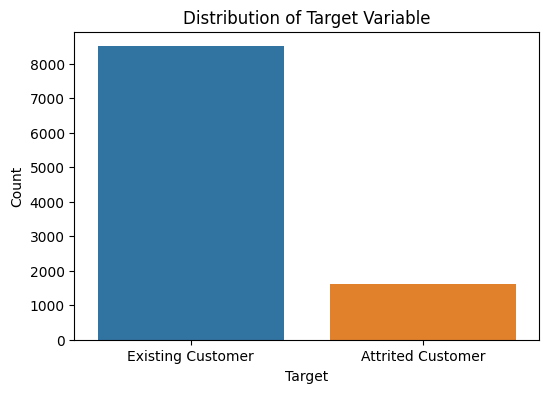

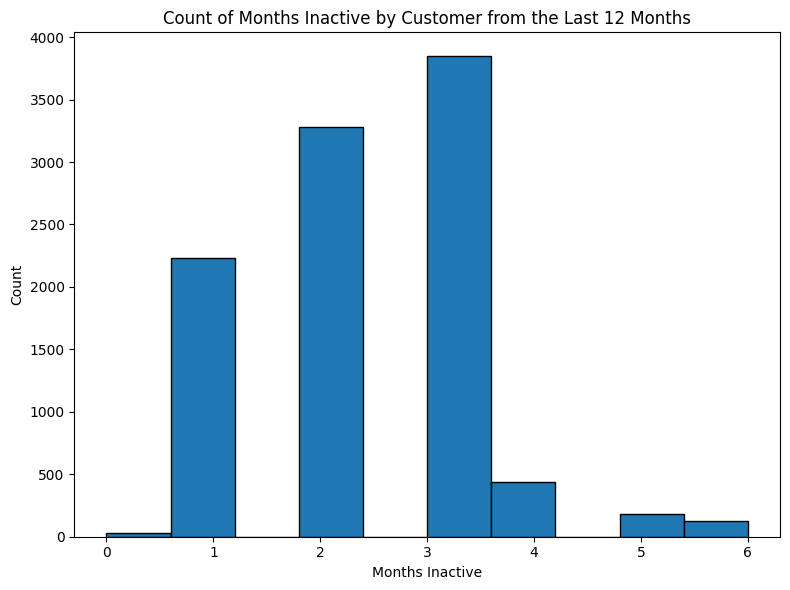

<ipython-input-5-3f6fb7676151>:49: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.drop('CLIENTNUM').toPandas().corr()


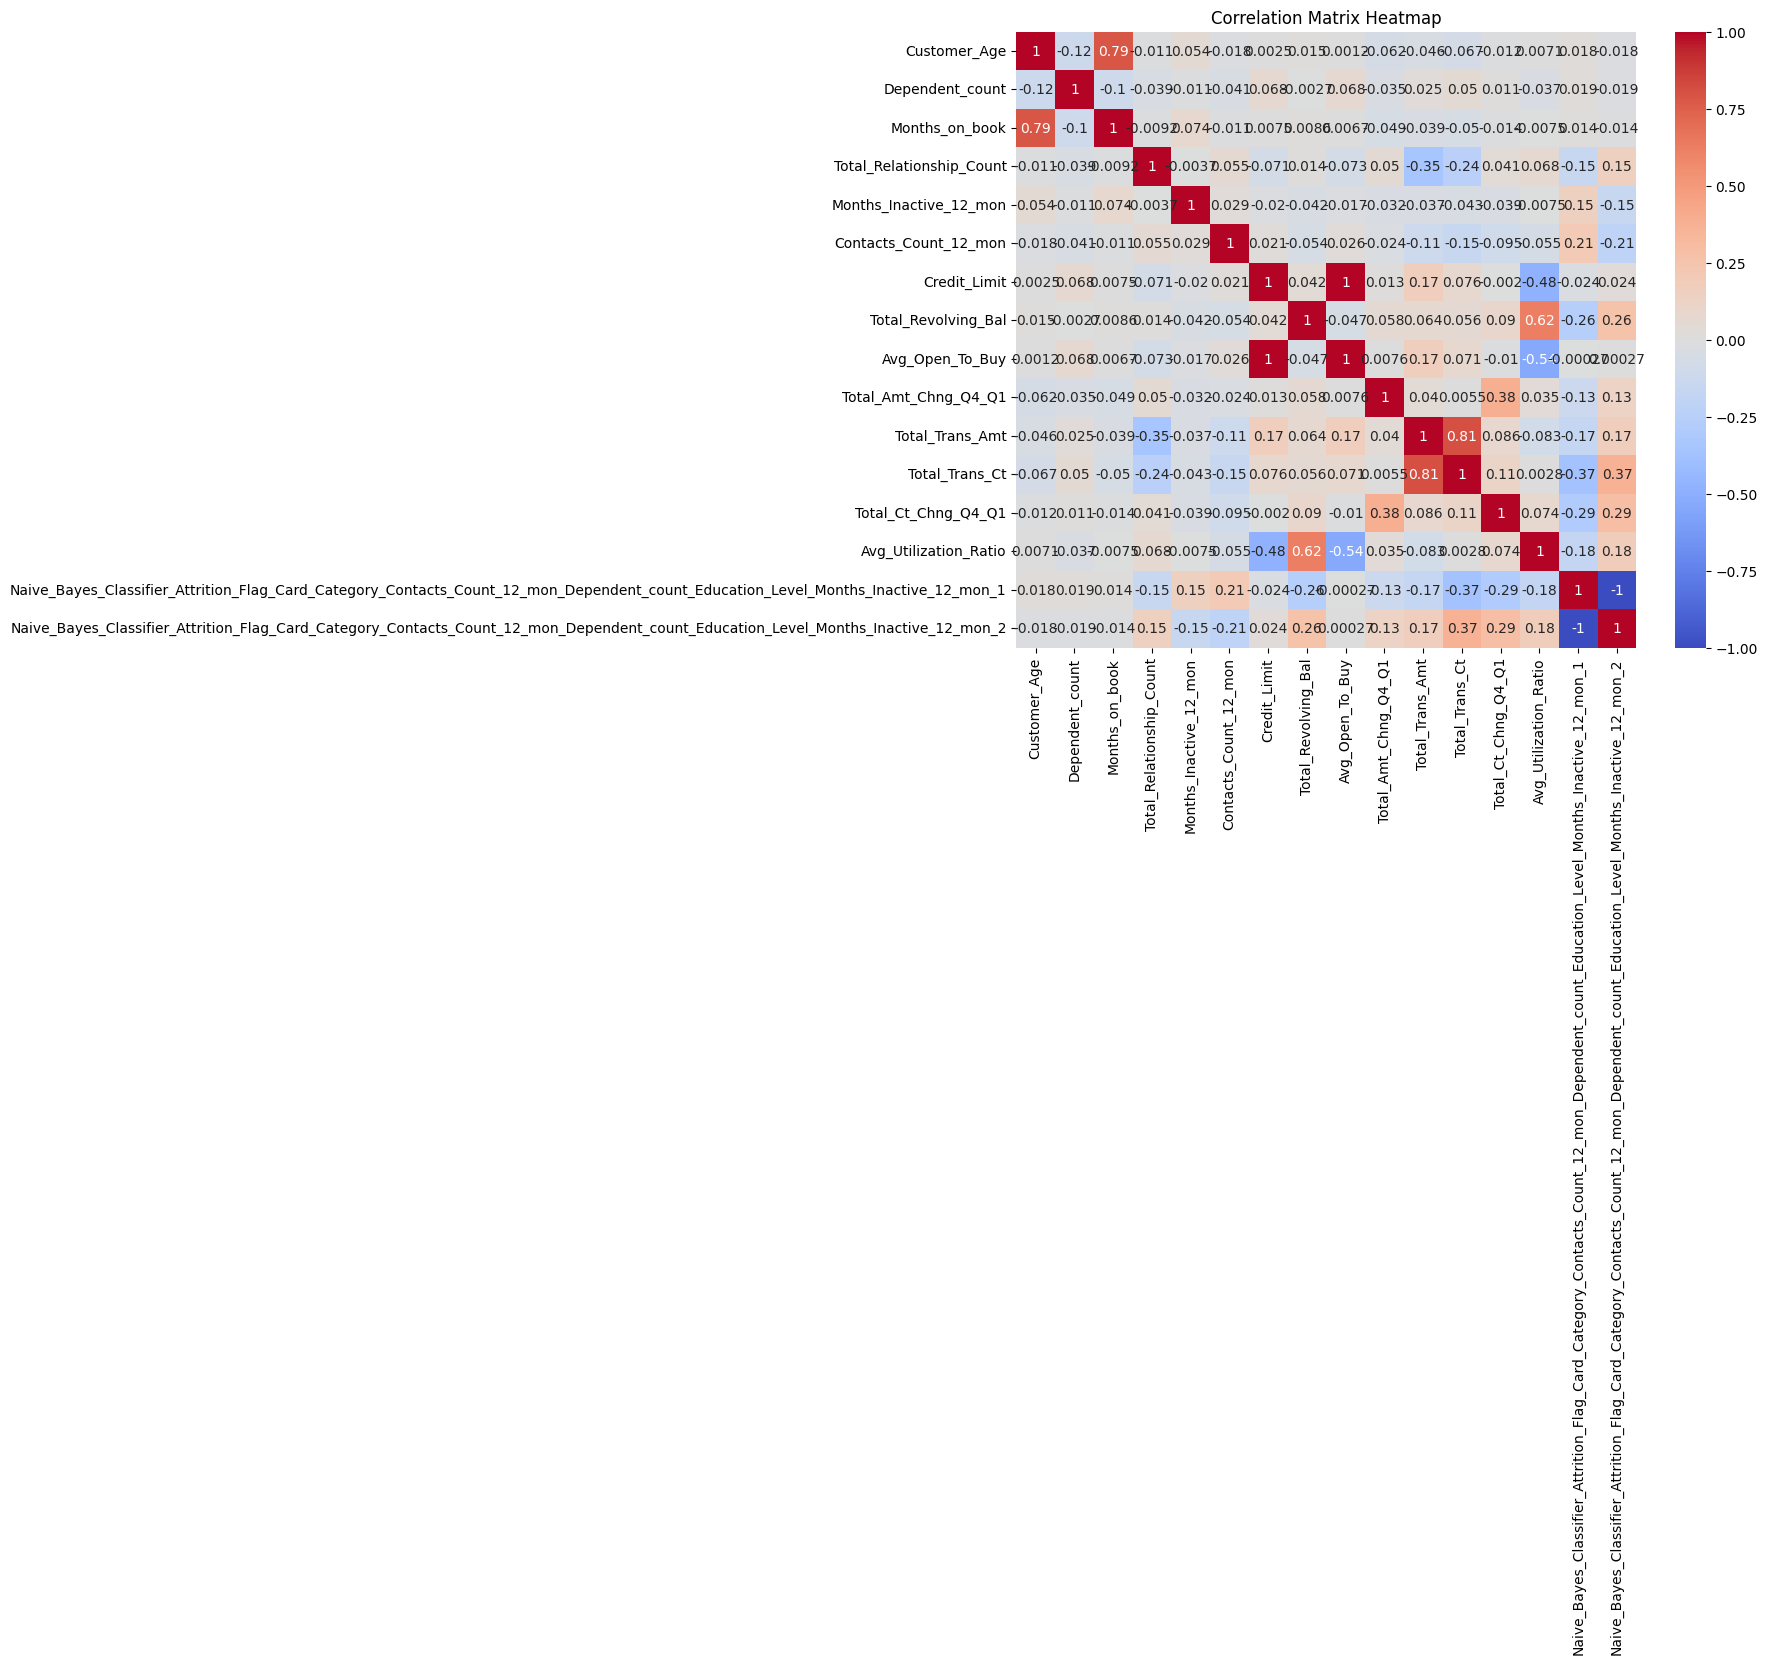

In [ ]:
# Install PySpark
!pip install pyspark

# Import required libraries
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder.appName("SparkExample").getOrCreate()

# Load the dataset
from google.colab import files
uploaded = files.upload()

data_path = list(uploaded.keys())[0]
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Visualize the distribution of the target variable
target_distribution = data.groupBy("Attrition_Flag").count().toPandas()

plt.figure(figsize=(6, 4))
sns.barplot(x='Attrition_Flag', y='count', data=target_distribution)

plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Filter the data for the last 12 months using Spark DataFrame operations
data_last_12_months = data.filter(data['Months_Inactive_12_mon'] <= 12)

# Convert Spark DataFrame to Pandas for histogram plotting
data_last_12_months_pd = data_last_12_months.select('Months_Inactive_12_mon').toPandas()

# Create a histogram for the count of months inactive by customer from the last 12 months
plt.figure(figsize=(8, 6))
plt.hist(data_last_12_months_pd['Months_Inactive_12_mon'], bins=10, edgecolor='k')
plt.title('Count of Months Inactive by Customer from the Last 12 Months')
plt.xlabel('Months Inactive')
plt.ylabel('Count')
plt.tight_layout()
plt.show()




# Calculate the correlation matrix using Spark DataFrame operations
correlation_matrix = data.drop('CLIENTNUM').toPandas().corr()

# Create a correlation matrix heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Stop Spark session
spark.stop()


In [ ]:

# Import necessary libraries for modeling and evaluation
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Encode the target column 'Attrition_Flag'
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="Attrition_Flag", outputCol="label")
df_transformed = indexer.fit(df_transformed).transform(df_transformed)

# Define the target column
target_column = "label"

# Split the dataset into training and testing sets
train_ratio = 0.8
test_ratio = 1.0 - train_ratio
train_data, test_data = df_transformed.randomSplit([train_ratio, test_ratio], seed=42)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(featuresCol="scaled_features", labelCol=target_column, seed=42)

# Define a grid of hyperparameters for tuning
param_grid = ParamGridBuilder() \
    .addGrid(rf_classifier.numTrees, [10, 20, 30]) \
    .addGrid(rf_classifier.maxDepth, [5, 10, 15]) \
    .build()

# Initialize BinaryClassificationEvaluator for evaluation
evaluator = BinaryClassificationEvaluator(labelCol=target_column)

# Initialize CrossValidator for hyperparameter tuning
cv = CrossValidator(estimator=rf_classifier, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, seed=42)

# Train the model using the training data
cv_model = cv.fit(train_data)

# Make predictions on the testing data
predictions = cv_model.transform(test_data)

# Evaluate the model's performance
roc_auc = evaluator.evaluate(predictions)
print(f"Area under ROC curve (AUC): {roc_auc}")




Area under ROC curve (AUC): 0.9864557380383389


An Area Under the ROC Curve (AUC) of 0.986 indicates that the Random Forest Classifier is performing very well on the test data. A high AUC value indicates a strong ability of the model to distinguish between the two classes; in this case, whether a customer churns or not. This is a positive outcome, suggesting that the data preprocessing, transformation, and modeling steps are working effectively.

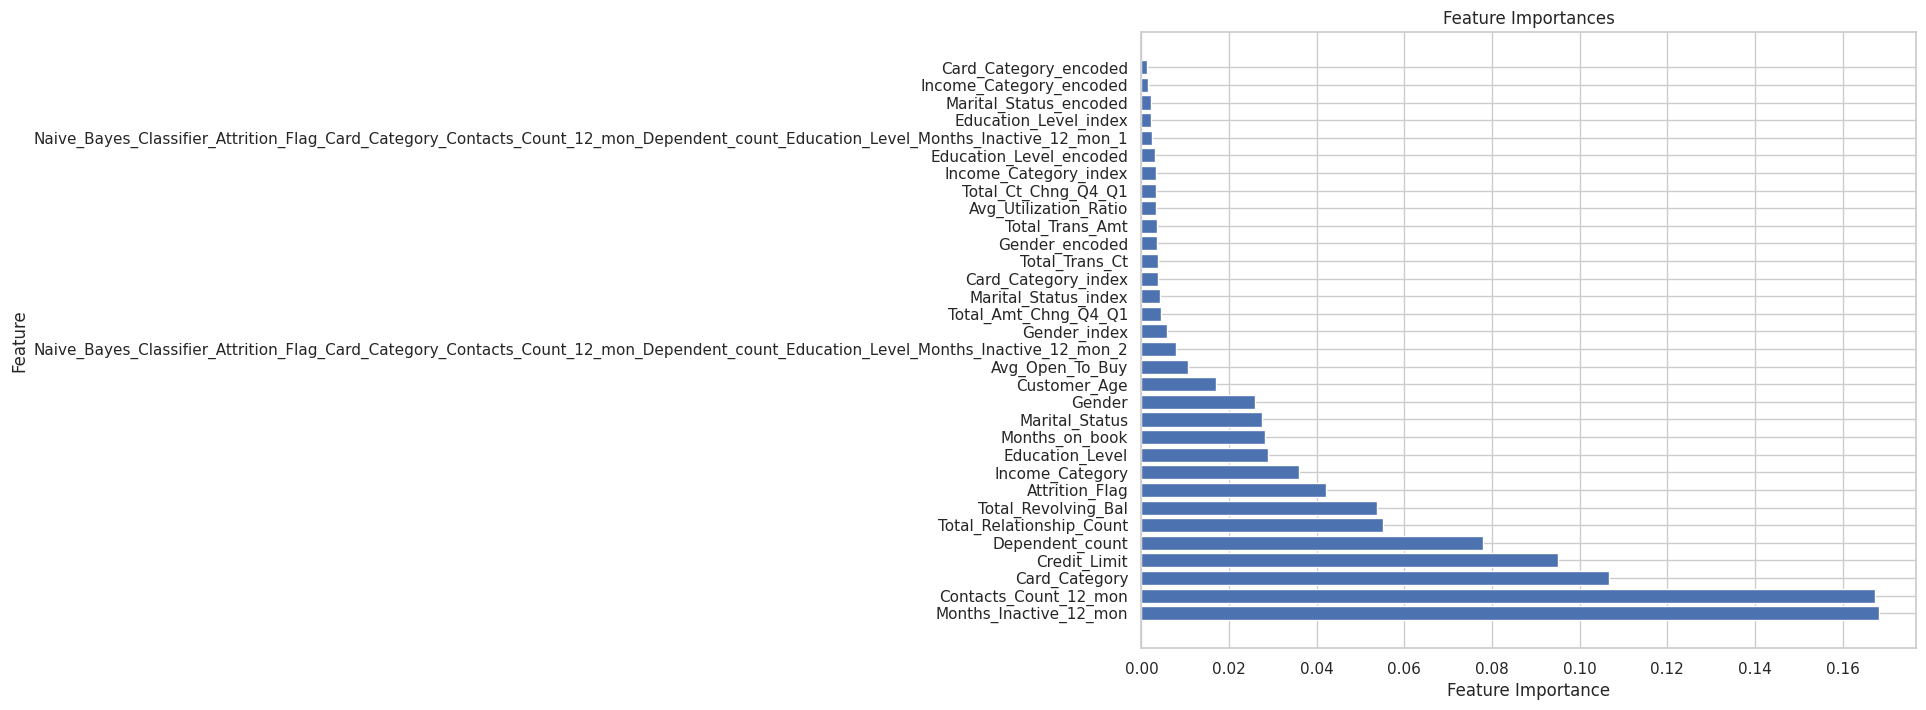

In [ ]:


from pyspark.ml.feature import IndexToString

# Convert the indexed labels back to original labels
label_converter = IndexToString(inputCol="label", outputCol="original_label")
predictions = label_converter.transform(predictions)

# Extract feature importances from the best model
feature_importances = cv_model.bestModel.featureImportances

# Extract feature names from the transformed DataFrame
feature_names = df_transformed.columns[:-2]  # Exclude the target column and scaled_features column

# Create a dictionary to store feature importances
feature_importance_dict = {}
for idx, importance in enumerate(feature_importances):
    feature_importance_dict[feature_names[idx]] = importance

# Sort the dictionary by importance in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract sorted feature names and importances
sorted_feature_names, sorted_importances = zip(*sorted_feature_importance)

# Visualize feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.show()


**Interpreting the graph:**

The x-axis represents the importance value of each feature.
The y-axis represents the names of the features.
Each bar in the graph corresponds to a feature, and the length of the bar represents the importance of that feature.
In this case on churn prediction for a credit card company, the graph can help us identify which features have the most influence on predicting whether a customer is likely to churn. This knowledge can guide decisions on improving customer retention strategies, understanding customer behavior, and potentially taking targeted actions to reduce churn.

Based on the feature importances graph you've observed, it appears that the feature "Months_Inactive_12_mon" has the highest importance value, while the feature "Card_Category_encoded" has the lowest importance value. This means that "Months_Inactive_12_mon" has the most significant impact on the model's predictions, while "Card_Category_encoded" has the least impact.

In the context of churn prediction for a credit card company, here's what this could potentially imply:

**Months Inactive in the Last 12 Months:** The fact that "Months_Inactive_12_mon" has the highest importance suggests that the number of months a customer has been inactive within the last year is a crucial factor in predicting churn. Customers who have been inactive for a longer period might be more likely to churn, indicating a potential need for engagement strategies targeted at reducing this inactivity.

**Card Category Encoded:** On the other hand, "Card_Category_encoded" having the lowest importance implies that the type of card a customer holds (encoded as a categorical feature) has relatively less influence on predicting churn compared to other features. This might mean that the type of card is not a strong indicator of customer churn in your current model.

**Evaluating Model Performance:**

In [ ]:


from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Initialize BinaryClassificationEvaluator for AUC-ROC evaluation
auc_roc_evaluator = BinaryClassificationEvaluator(labelCol=target_column, metricName="areaUnderROC")

# Initialize BinaryClassificationEvaluator for AUC-PR evaluation
auc_pr_evaluator = BinaryClassificationEvaluator(labelCol=target_column, metricName="areaUnderPR")

# Evaluate the model's performance using AUC-ROC
auc_roc = auc_roc_evaluator.evaluate(predictions)

# Evaluate the model's performance using AUC-PR
auc_pr = auc_pr_evaluator.evaluate(predictions)

print(f"AUC-ROC: {auc_roc}")
print(f"AUC-PR: {auc_pr}")



AUC-ROC: 0.9864557380383389
AUC-PR: 0.9285575221595657


we've successfully evaluated our model's performance using AUC-ROC and AUC-PR metrics. An AUC-ROC value close to 1 indicates that the model has a strong ability to distinguish between the positive and negative classes, while a high AUC-PR value indicates a good balance between precision and recall.

**Feature Engineering:**

Feature engineering involves creating new features or transforming existing ones to improve the model's performance.

In [ ]:
from pyspark.sql.functions import col

# Add squared term for Customer_Age
df_transformed = df_transformed.withColumn("Customer_Age_squared", col("Customer_Age") ** 2)



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction", metricName="accuracy")
accuracy = multiclass_evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.4f}")

precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
print(f"Weighted Precision: {precision:.4f}")

recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedRecall"})
print(f"Weighted Recall: {recall:.4f}")

f1_score = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})
print(f"F1 Score: {f1_score:.4f}")
from pyspark.ml.evaluation import BinaryClassificationEvaluator

pr_evaluator = BinaryClassificationEvaluator(labelCol=target_column, metricName="areaUnderPR")
auc_pr = pr_evaluator.evaluate(predictions)
print(f"AUC-PR: {auc_pr:.4f}")


Accuracy: 0.9558
Weighted Precision: 0.9547
Weighted Recall: 0.9558
F1 Score: 0.9542
AUC-PR: 0.9286


We've successfully evaluated the model's performance using various metrics. Here's what each metric means:

**Accuracy:**  The proportion of correctly predicted instances out of the total instances in the dataset. In this case, the accuracy is around 95.58%, indicating that the model is able to classify the majority of instances correctly.

**Weighted Precision:** The weighted average of precision across all classes, where each class's precision is weighted by the number of instances of that class. A high weighted precision value indicates that the model has a good balance between true positives and false positives.

**Weighted Recall: ** The weighted average of recall (true positive rate) across all classes, where each class's recall is weighted by the number of instances of that class. High weighted recall means the model is good at capturing positive instances.

**F1 Score: ** The harmonic mean of precision and recall. It provides a balance between precision and recall. A higher F1 score indicates a better balance between false positives and false negatives.

**AUC-PR (Area Under the Precision-Recall curve):** Measures the trade-off between precision and recall for different probability thresholds. A higher AUC-PR value indicates that the model is better at distinguishing between positive and negative instances.